In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, timedelta
import scipy.optimize
import seaborn as sns

dataFrame = pd.read_csv('Nat_Gas.csv', low_memory=False, parse_dates=['Dates']) 
prices = dataFrame['Prices']
dates = dataFrame['Dates']

print(dataFrame)

        Dates  Prices
0  2020-10-31   10.10
1  2020-11-30   10.30
2  2020-12-31   11.00
3  2021-01-31   10.90
4  2021-02-28   10.90
5  2021-03-31   10.90
6  2021-04-30   10.40
7  2021-05-31    9.84
8  2021-06-30   10.00
9  2021-07-31   10.10
10 2021-08-31   10.30
11 2021-09-30   10.20
12 2021-10-31   10.10
13 2021-11-30   11.20
14 2021-12-31   11.40
15 2022-01-31   11.50
16 2022-02-28   11.80
17 2022-03-31   11.50
18 2022-04-30   10.70
19 2022-05-31   10.70
20 2022-06-30   10.40
21 2022-07-31   10.50
22 2022-08-31   10.40
23 2022-09-30   10.80
24 2022-10-31   11.00
25 2022-11-30   11.60
26 2022-12-31   11.60
27 2023-01-31   12.10
28 2023-02-28   11.70
29 2023-03-31   12.00
30 2023-04-30   11.50
31 2023-05-31   11.20
32 2023-06-30   10.90
33 2023-07-31   11.40
34 2023-08-31   11.10
35 2023-09-30   11.50
36 2023-10-31   11.80
37 2023-11-30   12.20
38 2023-12-31   12.80
39 2024-01-31   12.60
40 2024-02-29   12.40
41 2024-03-31   12.70
42 2024-04-30   12.10
43 2024-05-31   11.40
44 2024-06

/var/folders/wx/c342xfyn5d79yh5st5d07n0w0000gn/T/ipykernel_13398/3911640910.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dataFrame = pd.read_csv('Nat_Gas.csv', low_memory=False, parse_dates=['Dates'])


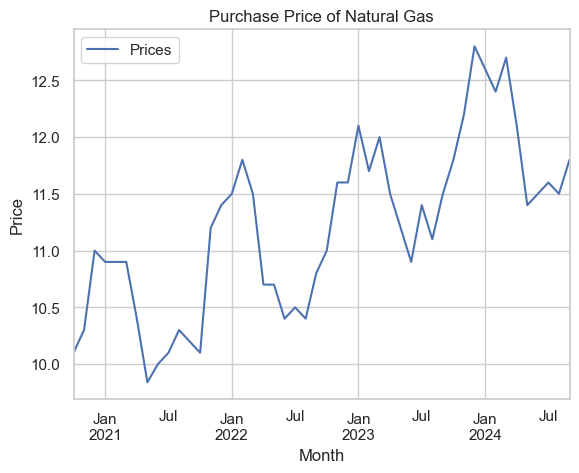

In [80]:
dataFrame.plot(x='Dates', y='Prices', kind='line')

plt.title('Purchase Price of Natural Gas')
plt.ylabel('Price')
plt.xlabel('Month')
plt.show()

# General increasing trend in natural gas purchase price
# Natural frequency approx. 1 year - local price peak in winter season 


In [81]:
# regression models to quantify trends

start_date = date(2020,10,31)
end_date = date(2024,9,30)

dataFrame['Days'] = (dataFrame['Dates'] - pd.to_datetime(start_date)).dt.days

# another way of calculating days from start
months = []
year = start_date.year
month = start_date.month + 1
while True:
    current = date(year, month, 1) + timedelta(days=-1)
    months.append(current)
    if current.month == end_date.month and current.year == end_date.year:
        break
    else:
        month = ((month + 1) % 12) or 12
        if month == 1:
            year += 1
        
days_from_start = [(day - start_date ).days for day in months]


In [101]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

X = dataFrame['Days'].values
Y = dataFrame['Prices'].values

X = X.reshape(-1,1)

model.fit(X, Y)

print("y-intercept of the linear fit:", model.intercept_)

print("gradient of the linear fit", model.coef_[0])

print(model.score(X, Y))

slope = model.coef_[0]
intercept = model.intercept_

y_fitted = model.predict(X)
dataFrame['Predicted'] = y_fitted

y-intercept of the linear fit: 10.29104112595228
gradient of the linear fit 0.001282373598760221
0.519596150757988


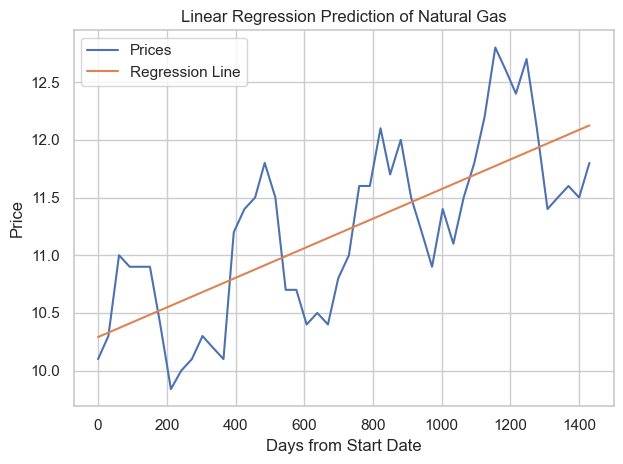

In [102]:
ax = dataFrame.plot(x='Days', y='Prices', kind='line')
dataFrame.plot(x='Days', y='Predicted', style='-', label='Regression Line', ax=ax)
plt.title('Linear Regression Prediction of Natural Gas')
plt.xlabel('Days from Start Date')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Smoothed Estimate of Monthly Input Prices')

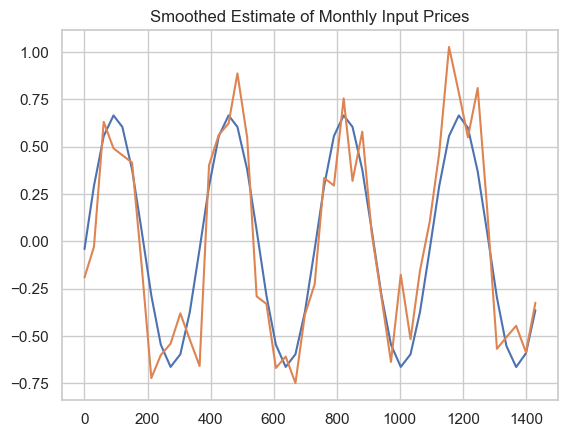

In [104]:
time = np.array(dataFrame['Days'].values)

sin_prices = prices - (time * slope + intercept)
sin_time = np.sin(time * 2 * np.pi / (365))
cos_time = np.cos(time * 2 * np.pi / (365))

def bilinear_regression(y, x1, x2):
    # Bilinear regression without an intercept amounts to projection onto the x-vectors
    slope1 = np.sum(y * x1) / np.sum(x1 ** 2)
    slope2 = np.sum(y * x2) / np.sum(x2 ** 2)
    return(slope1, slope2)

slope1, slope2 = bilinear_regression(sin_prices, sin_time, cos_time)

# We now recover the original amplitude and phase shift as A = slope1 ** 2 + slope2 ** 2, z = tan^{-1}(slope2/slope1)
amplitude = np.sqrt(slope1 ** 2 + slope2 ** 2)
shift = np.arctan2(slope2, slope1)

# Plot smoothed estimate of full dataset
plt.plot(time, amplitude * np.sin(time * 2 * np.pi / 365 + shift))
plt.plot(time, sin_prices)
plt.title('Smoothed Estimate of Monthly Input Prices')



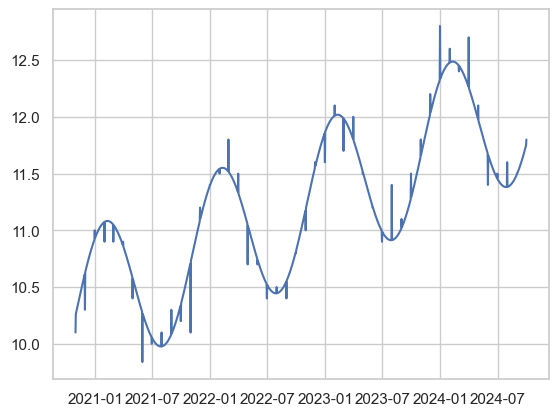

In [105]:
# Define the interpolation/extrapolation function
def interpolate(date):
    days = (date - pd.Timestamp(start_date)).days
    if days in days_from_start:
        # Exact match found in the data
        return prices[days_from_start.index(days)]
    else:
        # Interpolate/extrapolate using the sin/cos model
        return amplitude * np.sin(days * 2 * np.pi / 365 + shift) + days * slope + intercept

# Create a range of continuous dates from start date to end date
continuous_dates = pd.date_range(start=pd.Timestamp(start_date), end=pd.Timestamp(end_date), freq='D')

# Plot the smoothed estimate of the full dataset using interpolation
plt.plot(continuous_dates, [interpolate(date) for date in continuous_dates], label='Smoothed Estimate')




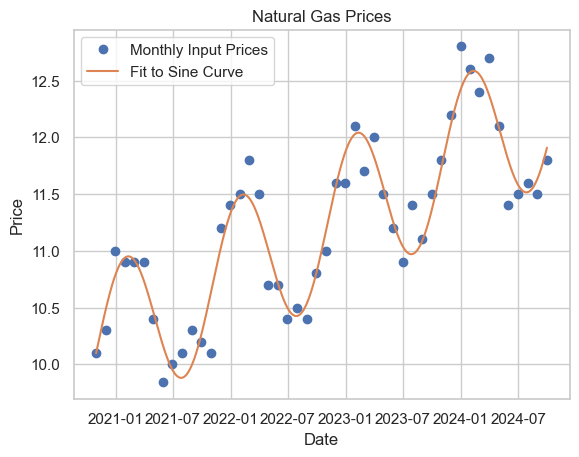

In [106]:
# Fit the monthly input prices to the sine curve
x = np.array(days_from_start)
y = np.array(prices)
fit_amplitude = np.sqrt(slope1 ** 2 + slope2 ** 2)
fit_shift = np.arctan2(slope2, slope1)
fit_slope, fit_intercept = simple_regression(x, y - fit_amplitude * np.sin(x * 2 * np.pi / 365 + fit_shift))
plt.plot(dates, y, 'o', label='Monthly Input Prices')
plt.plot(continuous_dates, fit_amplitude * np.sin((continuous_dates - pd.Timestamp(start_date)).days * 2 * np.pi / 365 + fit_shift) + (continuous_dates - pd.Timestamp(start_date)).days * fit_slope + fit_intercept, label='Fit to Sine Curve')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Natural Gas Prices')
plt.legend()
plt.show()
